# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.909372,False,-3.816011
1,-0.898591,False,0.378916
2,-1.431050,False,-2.105012
3,0.819256,False,1.838267
4,-2.302500,False,-2.387011
...,...,...,...
995,0.220665,True,5.124087
996,-0.335086,False,-1.867750
997,-0.522384,True,5.446104
998,-2.361378,False,-4.322914


<AxesSubplot:xlabel='v0'>

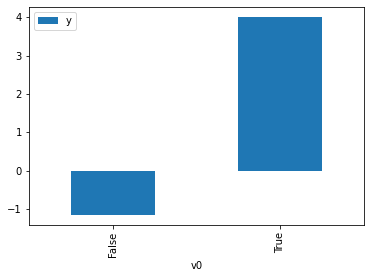

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

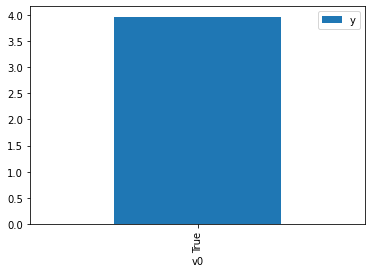

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-2.337423,False,-2.701638,0.835793,1.196468
1,0.840838,False,2.161990,0.352237,2.838998
2,-1.563359,False,-0.938637,0.746978,1.338727
3,-0.782944,False,0.194310,0.630276,1.586607
4,0.508672,False,-0.041139,0.407217,2.455694
...,...,...,...,...,...
995,-1.786933,False,-2.775262,0.775544,1.289417
996,-0.264682,False,2.595709,0.542078,1.844754
997,-1.570611,False,-1.929112,0.747942,1.337002
998,-0.186154,False,1.156149,0.528333,1.892747


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-1.002054,True,4.199066,0.334571,2.988903
1,-1.985827,True,5.658613,0.201034,4.974279
2,-0.667286,True,3.486733,0.388882,2.571474
3,-1.555183,True,3.095015,0.254110,3.935296
4,-3.414442,True,1.005622,0.084314,11.860473
...,...,...,...,...,...
995,-1.036556,True,3.381018,0.329188,3.037782
996,0.417158,True,7.156251,0.577150,1.732651
997,-0.160388,True,6.417523,0.476188,2.100011
998,-0.900087,True,3.802231,0.350730,2.851195


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.897
Model:                            OLS   Adj. R-squared (uncentered):              0.897
Method:                 Least Squares   F-statistic:                              4340.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):                        0.00
Time:                        20:32:58   Log-Likelihood:                         -1422.9
No. Observations:                1000   AIC:                                      2850.
Df Residuals:                     998   BIC:                                      2860.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.0487      0.024     44.479      0.000       1.002       1.095
x2             5.0082      0.055     90.392      0.000       4.900       5.117
==============================================================================
Omnibus:                        1.017   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.602   Jarque-Bera (JB):                1.062
Skew:                           0.025   Prob(JB):                        0.588
Kurtosis:                       2.849   Cond. No.                         2.46
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""